# Pre-processing Step 1
## Reading Trajectory Data
First we start by reading trajectory data using PTRAIL, which will provide the data structures necessary to handle the spatio-temporal dependencies on the data.

In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from ptrail.features.semantic_features import SemanticFeatures

pdf = pd.read_csv('./starkey_new.csv')
starkey = PTRAILDataFrame(data_set=pdf,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print(starkey)


------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


# Pre-processing Step 2
## Create Trajectory Features

Generate the kinematic statistics.
This method creates first a point-based representation for features: distance between points distance travelled from start, speed (m/s), acceleration (m/s2), jerk, bearing, bearing rate, and rate of bearing rate (8 point features).
After, the method extracts statistics from all these features, including:
minimum, maximal, standard deviation, mean, and percentiles 10, 25, 50, 75 and 90.
The statistics extracted are a trajectory(segment)-based representation of the trajectory dataset and can be used for several problems.
For data visualization purposes, the outcomes of this method are grouped by
point-feature attribute.

In [2]:
%%time

# generate Kinematic stats.
stats = Statistics.generate_kinematic_stats(dataframe=starkey,
                                            target_col_name='Species')

CPU times: user 29.5 s, sys: 750 ms, total: 30.3 s
Wall time: 31.9 s


# Pre-processing Step 3
## Pivot the frame to create a feature vector
To change the representation in a way we can assign one label per trajectory (segment)
The user just need to call the method pivot_stats_df and all trajectory-based features will be pivoted for machine learning tasks as can be seen below

In [3]:
# Pivot the stats df and get it ready for the ML task.
pivoted_stats = Statistics.pivot_stats_df(dataframe=stats,
                                          target_col_name='Species')
pivoted_stats

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022359,66.956787,149.611989,300.726867,632.269559,0.000000,6034.207873,268.728974,398.901980,1121.185006,...,-0.063322,-0.026677,5.306679e-08,0.025072,0.065316,-6.036678,2.449554,-0.001945,0.154034,1
890424E08,42.384642,84.780370,177.223376,379.614004,759.311144,0.000000,6043.490157,323.956468,446.249248,674.170024,...,-0.064023,-0.023545,0.000000e+00,0.022320,0.063820,-11.536372,2.494857,-0.006703,0.241358,1
921228E06,42.390114,90.066813,200.849995,429.158672,890.194719,0.000000,4623.347553,377.677630,517.650637,807.693739,...,-0.058033,-0.020736,-9.056581e-07,0.020104,0.056057,-56.020652,4.466711,-0.016681,1.008263,1
930304E16,42.384012,67.090258,153.068542,341.254645,690.640774,0.000000,5864.020183,291.351804,396.220730,1156.455188,...,-0.068092,-0.026542,2.094546e-07,0.027375,0.066328,-7.865121,30.406105,0.001768,0.600187,1
940110D01,30.022192,66.956668,149.612107,284.710015,510.276991,0.000000,1975.611748,221.420080,235.093739,492.522877,...,-0.041207,-0.018263,0.000000e+00,0.018564,0.042032,-5.547235,200.192244,0.073830,3.677063,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384783,98.213522,275.921086,509.415791,1734.539050,0.000000,4968.850596,552.252200,797.302786,2019.896767,...,-0.013195,-0.006290,-1.456657e-04,0.006863,0.019363,-0.180602,0.032870,-0.001012,0.022347,2
OSUX92008,60.044073,113.846901,323.971240,582.606358,1036.441333,0.000000,3252.044721,469.226709,565.038959,2330.556507,...,-0.033016,-0.006065,4.739615e-05,0.008182,0.023711,-0.119311,0.119162,-0.001884,0.033022,2
OSUX91121,66.956676,138.476526,334.746006,596.234364,1365.947767,42.390056,5886.617958,652.055638,1119.869470,2660.409775,...,-0.010799,-0.003606,1.840711e-04,0.006951,0.023679,-0.018316,0.027926,0.001982,0.011728,2


# Pre-processing Step 4
## Feature Selection

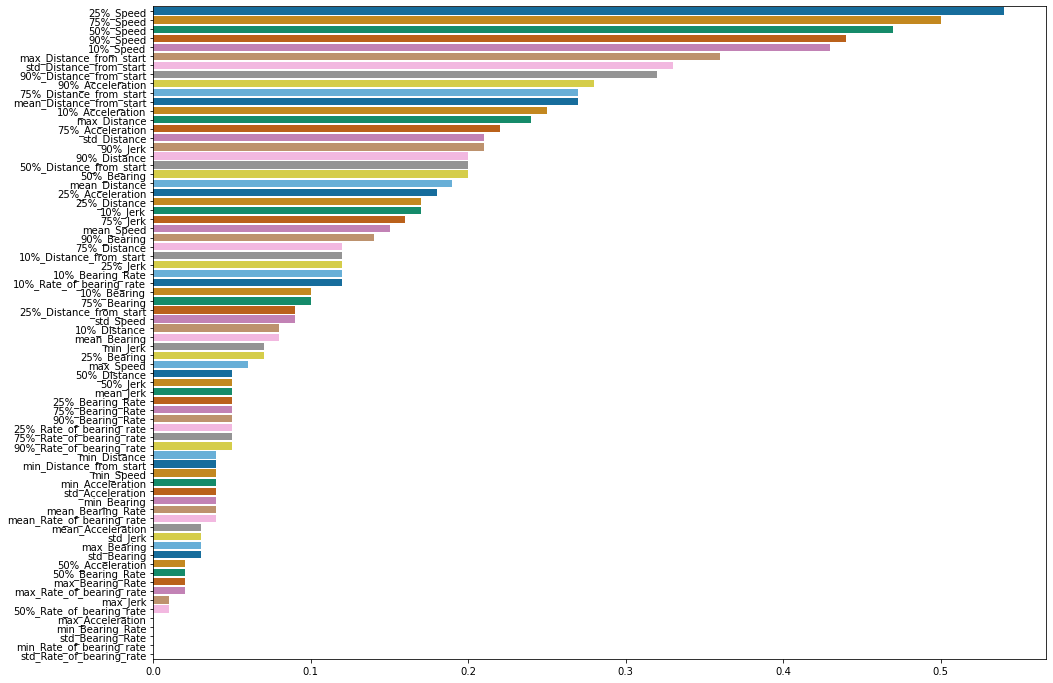

In [4]:
# Visualization tools.
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-selecting features
from sklearn.feature_selection import mutual_info_classif
from operator import itemgetter
import numpy as np

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats.drop(columns='Species').to_numpy()
Y = pivoted_stats['Species'].to_numpy()

mutual_info = mutual_info_classif(X,Y)
feat_list = []
for column, minfo in zip(pivoted_stats.columns, mutual_info):
  feat_list.append([column, round(minfo, 2)])

# Sort the selected features and then convert it to a numpy array
# and make sure that the datatypes are correctly assigned.
sorted_flist = sorted(feat_list, key=itemgetter(1), reverse=True)
flist = np.array(sorted_flist)
f_names = flist[:,0].astype(np.unicode_)
minfo = flist[:,1].astype(np.float16)

fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(x=minfo, y=f_names, ax=ax, palette='colorblind')

# select elements greater than .20
final_list = [i for i in sorted_flist if i[1] >= .2]
selected_cols = [i[0] for i in final_list]

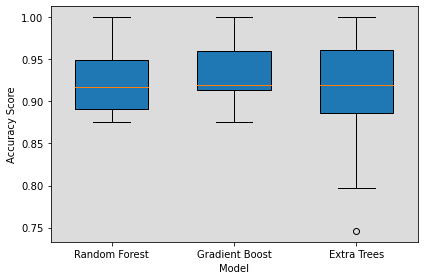

In [5]:
# Models.
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# Metric calculation.
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Declare all the models that we are going to train.
names = ["Random Forest", "Gradient Boost", "Extra Trees"]
models = [RandomForestClassifier(), ExtraTreesClassifier(),
          GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)]

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats[selected_cols]
Y = pivoted_stats['Species'].to_numpy()

ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
# For each model defined above, predict the species for
# our animals.
for i, name, model in zip(range(0, 4), names, models):
    fit = model.fit(X, Y)
    scores = cross_val_score(model, X, Y,
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i],
               vert=True, widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Model")
plt.tight_layout()

<function amin at 0x7ff3c4070430>
<function amin at 0x7ff3c4070430>
<function amin at 0x7ff3c4070430>


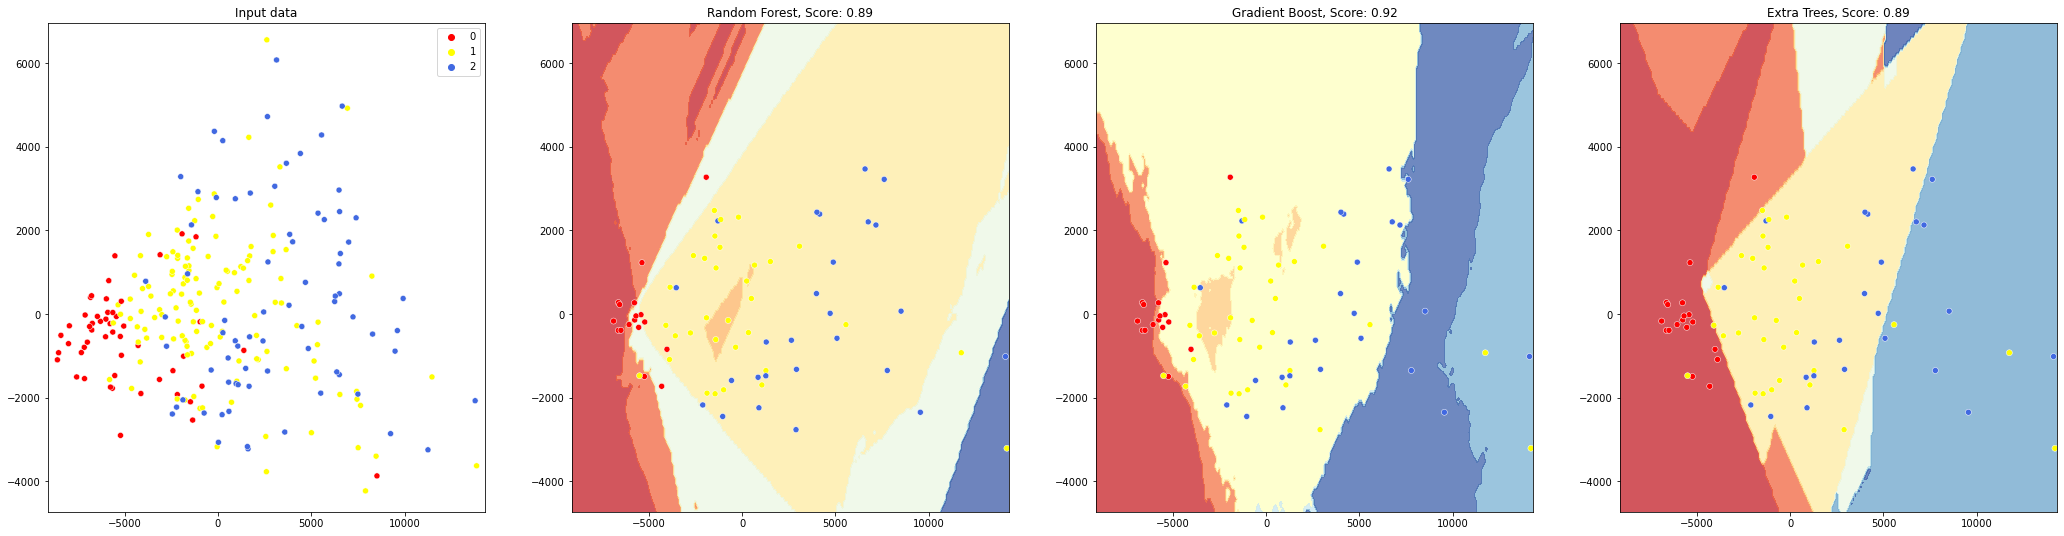

In [6]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Perform PCA on our df and extract 2 components for visualization purposes.
pca2 = PCA(n_components=2)
transformed2 = pca2.fit_transform(X=X)

# Prepare next figure
fig2, ax2 = plt.subplots(1, 4, figsize=(36, 9))
fig2.set_facecolor('white')
ax2=ax2.flatten()

h = 100
x_min, x_max = transformed2[:, 0].min() - 500, transformed2[:, 0].max() + 500
y_min, y_max = transformed2[:, 1].min() - 500, transformed2[:, 1].max() + 500
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdYlBu
cm_bright = ListedColormap(["#FF0000", "#FFFF00", "#00FF00"])

ax2[0].set_title("Input data")
# Plot all points of the dataset.
sns.scatterplot(x=transformed2[:, 0], y=transformed2[:, 1],
                hue=Y, ax=ax2[0], palette=['red', 'yellow', 'royalblue'])
ax2[0].set_xlim(xx.min(), xx.max())
ax2[0].set_ylim(yy.min(), yy.max())
# ax2[0].get_legend().remove()

for i, name, model in zip(range(1, len(ax2)), names, models):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    hue = model.predict(X_test)

    # Convert the mesh back to the original values.
    real_X = pca2.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    print(np.min)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z_vals = model.predict_proba(real_X)

    # Now we will perform the calculation for the
    # colormap gradient and then convert the list to a numpy array.
    Z = []
    for j in range(len(Z_vals)):
        val = (np.argmax(Z_vals[j]) + 1) - Z_vals[j][np.argmax(Z_vals[j])]
        Z.append(val)
    Z = np.array(Z)

    # Scale the z-values to be between 0 and 2.
    scaler = MinMaxScaler(feature_range=(0, 2))
    scaler.fit(Z.reshape(-1, 1))
    Z = scaler.transform(Z.reshape(-1, 1))

    # Reshape the array and then plot the contour plot.
    Z = Z.reshape(xx.shape)
    ax2[i].contourf(xx, yy, Z, cmap=cm, alpha=0.75)

    # Now, we plot the points onto the contour and then map their
    # colors according to the regions.
    sns.scatterplot(x=pca2.fit_transform(X_test)[:, 0], y=pca2.fit_transform(X_test)[:, 1],
                    hue=hue, ax=ax2[i], palette=['red', 'yellow', 'royalblue'])

    ax2[i].set_title(name + f', Score: {round(score, 2)}')
    ax2[i].get_legend().remove()

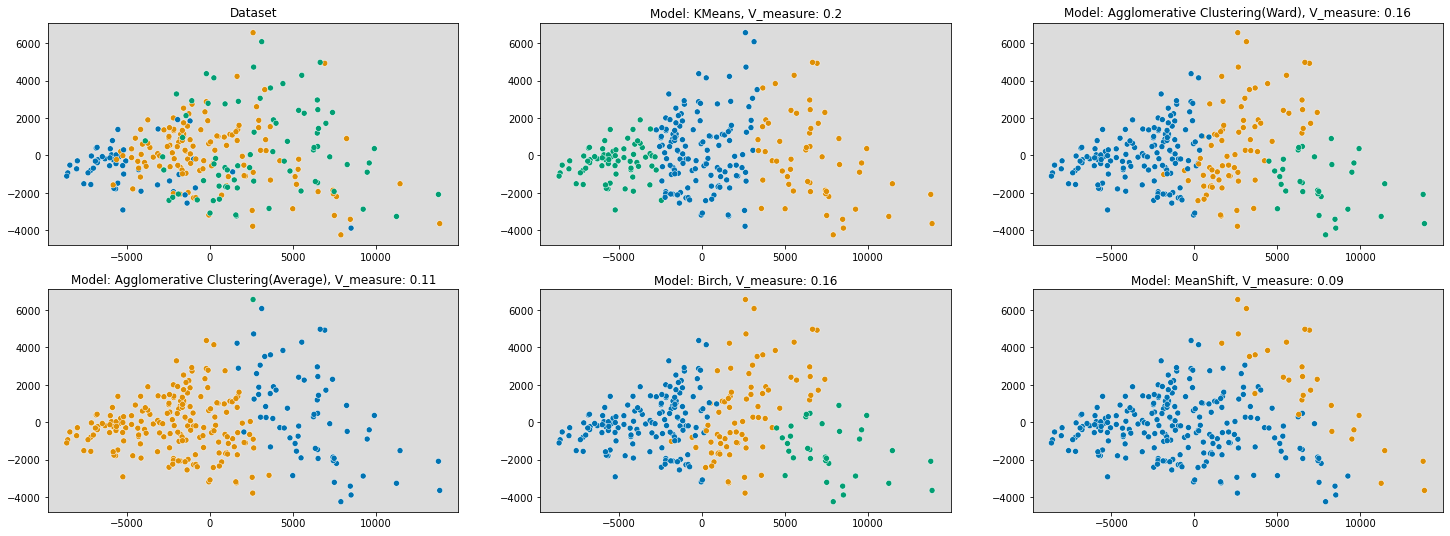

In [7]:
# 2. Clustering Pipeline.
# from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, Birch, KMeans, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import v_measure_score

# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X, quantile=0.25)

cluster_models = [
    KMeans(n_clusters=3, algorithm='elkan'),
    AgglomerativeClustering(n_clusters=3),
    AgglomerativeClustering(linkage="average", n_clusters=3),
    Birch(n_clusters=3),
    MeanShift(bandwidth=bandwidth, bin_seeding=True),
]

cluster_names = ['KMeans', 'Agglomerative Clustering(Ward)', 'Agglomerative Clustering(Average)', 'Birch', 'MeanShift']

# Perform PCA on our df and extract 2 components for visualization purposes.
pca = PCA(n_components=2)
transformed = pca.fit_transform(X=X)

# Plot true clusters
# sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    # hue=Y, palette='colorblind')


# Prepare next figure
fig1, ax1 = plt.subplots(2, 3, figsize=(25, 9))
fig1.set_facecolor('white')
ax1=ax1.flatten()

sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=Y, palette='colorblind', ax=ax1[0])
ax1[0].set_title(f'Dataset')
ax1[0].get_legend().remove()
ax1[0].set_facecolor('gainsboro')

# Training the models first and doing their box plots.
for i, name, model in zip(range(0, len(ax1)), cluster_names, cluster_models):
    # Predict the species on the test dataset.
    ans = model.fit_predict(X)
    # calculating v_measure
    score = v_measure_score(Y, model.labels_)
    # Plot the 2D scatterplot and then set the title of each plot.
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    hue=ans, palette='colorblind', ax=ax1[i+1])
    ax1[i+1].set_title(f'Model: {name}, V_measure: {round(score, 2)}')
    ax1[i+1].get_legend().remove()
    ax1[i+1].set_facecolor('gainsboro')

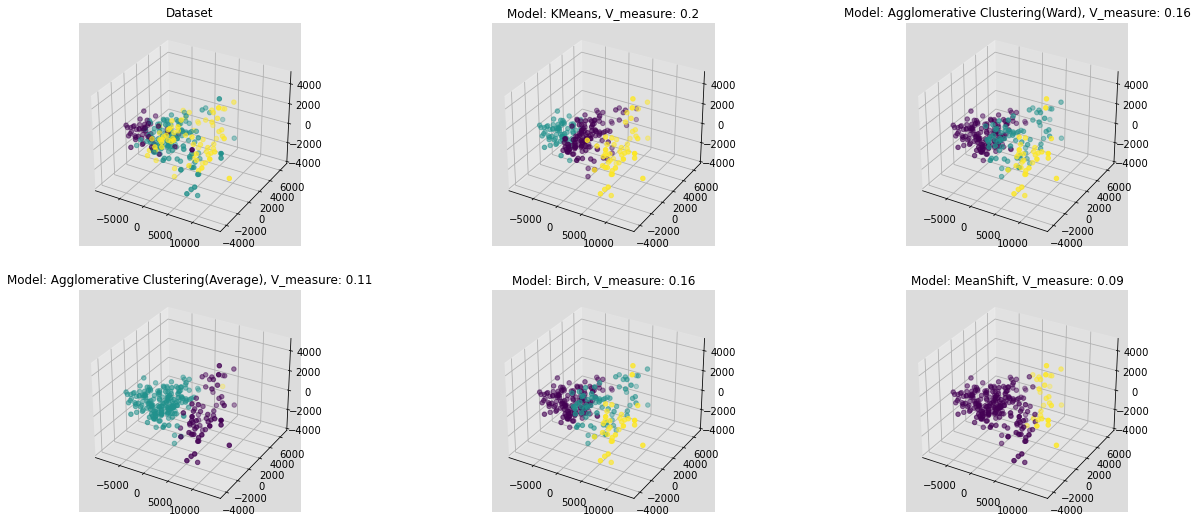

In [8]:
# 2. Clustering Pipeline.
# from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, Birch, KMeans, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import  v_measure_score
from mpl_toolkits.mplot3d import axes3d


# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X, quantile=0.25)

cluster_models = [
    KMeans(n_clusters=3, algorithm='elkan'),
    AgglomerativeClustering(n_clusters=3),
    AgglomerativeClustering(linkage="average", n_clusters=3),
    Birch(n_clusters=3),
    MeanShift(bandwidth=bandwidth, bin_seeding=True),
]

cluster_names = ['KMeans', 'Agglomerative Clustering(Ward)', 'Agglomerative Clustering(Average)', 'Birch', 'MeanShift']

# Perform PCA on our df and extract 2 components for visualization purposes.
pca = PCA(n_components=3)
transformed = pca.fit_transform(X=X)

# Prepare next figure
fig1, ax1 = plt.subplots(2, 3, figsize=(21, 9), subplot_kw={'projection': '3d'})
fig1.set_facecolor('white')
ax1 = ax1.flatten()

ax1[0].scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], marker='o', c=Y)
ax1[0].set_title(f'Dataset')
ax1[0].set_facecolor('gainsboro')

# Training the models first and doing their box plots.
for i, name, model in zip(range(0, len(ax1)), cluster_names, cluster_models):
    # Predict the species on the test dataset.
    ans = model.fit_predict(X)
    # calculating v_measure
    score = v_measure_score(Y, model.labels_)

    # Plot the 3D scatterplot and then set the title of each plot.
    ax1[i + 1].scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], marker='o', c=ans)
    ax1[i+1].set_title(f'Model: {name}, V_measure: {round(score, 2)}')
    ax1[i+1].set_facecolor('gainsboro')

In [9]:
three_month_seg = Statistics.segment_traj_by_days(starkey, 90)
three_month_seg

lat         lon  StarkeyTime  \
traj_id   seg_id DateTime                                                  
880119D02 1      1993-05-18 14:04:36  45.245158 -118.527618    169855476   
                 1993-05-18 14:41:26  45.244873 -118.528757    169857686   
                 1993-05-18 15:17:29  45.245148 -118.528382    169859849   
                 1993-05-18 15:54:58  45.243803 -118.527964    169862098   
                 1993-05-18 17:05:50  45.243814 -118.527199    169866350   
...                                         ...         ...          ...   
OSUX89078 1      1993-08-15 06:26:50  45.220516 -118.591916    177517610   
                 1993-08-15 07:32:49  45.220558 -118.588860    177521569   
                 1993-08-15 08:40:24  45.220553 -118.589242    177525624   
                 1993-08-15 13:12:14  45.220299 -118.588089    177541934   
                 1993-08-15 14:23:23  45.220526 -118.591152    177546203   

                                        GMDate    GMTime   LocDate   LocTime  \
traj_id   seg_id DateTime                                                      
880119D02 1      1993-05-18 14:04:36  22:04:36  19930518  19930518  14:04:36   
                 1993-05-18 14:41:26  22:41:26  19930518  19930518  14:41:26   
                 1993-05-18 15:17:29  23:17:29  19930518  19930518  15:17:29   
                 1993-05-18 15:54:58  23:54:58  19930518  19930518  15:54:58   
                 1993-05-18 17:05:50  01:05:50  19930519  19930518  17:05:50   
...                                        ...       ...       ...       ...   
OSUX89078 1      1993-08-15 06:26:50  14:26:50  19930815  19930815  06:26:50   
                 1993-08-15 07:32:49  15:32:49  19930815  19930815  07:32:49   
                 1993-08-15 08:40:24  16:40:24  19930815  19930815  08:40:24   
                 1993-08-15 13:12:14  21:12:14  19930815  19930815  13:12:14   
                 1993-08-15 14:23:23  22:23:23  19930815  19930815  14:23:23   

                                      RadNum  Species    UTME     UTMN  Year  \
traj_id   seg_id DateTime                                                      
880119D02 1      1993-05-18 14:04:36     187        0  380126  5011313    93   
                 1993-05-18 14:41:26     187        0  380019  5011283    93   
                 1993-05-18 15:17:29     187        0  380064  5011312    93   
                 1993-05-18 15:54:58     187        0  380084  5011165    93   
                 1993-05-18 17:05:50     187        0  380132  5011164    93   
...                                      ...      ...     ...      ...   ...   
OSUX89078 1      1993-08-15 06:26:50     172        2  375013  5008672    93   
                 1993-08-15 07:32:49     172        2  375244  5008671    93   
                 1993-08-15 08:40:24     172        2  375215  5008669    93   
                 1993-08-15 13:12:14     172        2  375308  5008641    93   
                 1993-08-15 14:23:23     172        2  375072  5008677    93   

                                      Grensunr  Grensuns  Obswt        Date  
traj_id   seg_id DateTime                                                    
880119D02 1      1993-05-18 14:04:36  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 14:41:26  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 15:17:29  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 15:54:58  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 17:05:50  12:20:00  03:24:00   1.39  1993-05-18  
...                                        ...       ...    ...         ...  
OSUX89078 1      1993-08-15 06:26:50  12:56:00  03:04:00   1.66  1993-08-15  
                 1993-08-15 07:32:49  12:56:00  03:04:00   1.45  1993-08-15  
                 1993-08-15 08:40:24  12:56:00  03:04:00   1.45  1993-08-15  
                 1993-08-15 13:12:14  12:56:00  03:04:00   1.45  1993-08-15  
                 1993-08-15 14:23:23 